In [15]:
!pip install pyannote.audio librosa soundfile scipy matplotlib

In [16]:
!pip show pyannote.audio

Name: pyannote.audio
Version: 3.3.2
Summary: Neural building blocks for speaker diarization
Home-page: https://github.com/pyannote/pyannote-audio
Author: Hervé Bredin
Author-email: herve.bredin@irit.fr
License: mit
Location: C:\Users\aksha\anaconda3\Lib\site-packages
Requires: asteroid-filterbanks, einops, huggingface-hub, lightning, omegaconf, pyannote.core, pyannote.database, pyannote.metrics, pyannote.pipeline, pytorch-metric-learning, rich, semver, soundfile, speechbrain, tensorboardX, torch, torch-audiomentations, torchaudio, torchmetrics
Required-by: 


In [17]:
!pip install librosa

In [18]:
!pip show pyannote.audio

Name: pyannote.audio
Version: 3.3.2
Summary: Neural building blocks for speaker diarization
Home-page: https://github.com/pyannote/pyannote-audio
Author: Hervé Bredin
Author-email: herve.bredin@irit.fr
License: mit
Location: C:\Users\aksha\anaconda3\Lib\site-packages
Requires: asteroid-filterbanks, einops, huggingface-hub, lightning, omegaconf, pyannote.core, pyannote.database, pyannote.metrics, pyannote.pipeline, pytorch-metric-learning, rich, semver, soundfile, speechbrain, tensorboardX, torch, torch-audiomentations, torchaudio, torchmetrics
Required-by: 


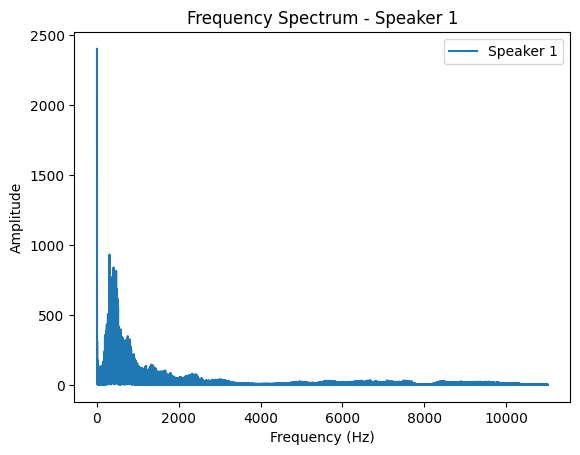

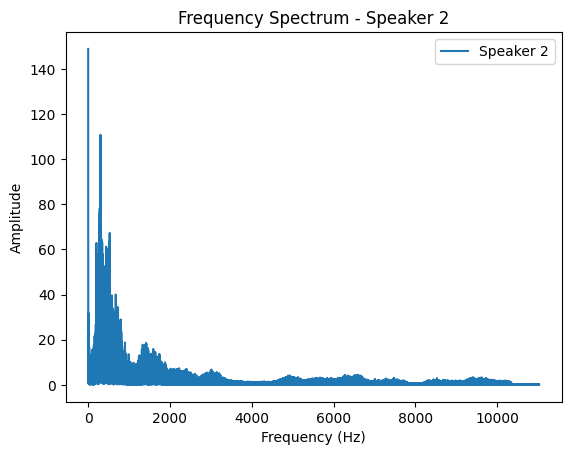

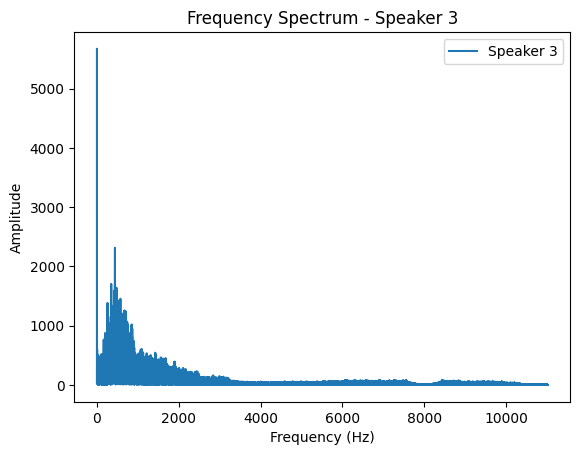

Dominant frequencies for each speaker:
Speaker 1: [410.89360955 367.51612974 307.40980513 417.2878994  406.71139835
 469.23718399 405.63992275 317.2950316  307.51349631   0.        ]
Speaker 2: [282.45664675 278.72135788 280.53985378 291.54912625 284.76662803
 287.46979761 288.84595667 281.0804877  299.90437767   0.        ]
Speaker 3: [439.9125966  440.9402115  441.22047011 441.12705057 440.37969428
 440.42640405 440.80008219 440.23956497 440.51982358   0.        ]


In [11]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load Audio and Extract Features
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def extract_features(audio, sr, hop_length=512):
    # Extract MFCCs for speaker features, with the same hop_length for alignment
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=hop_length)
    return mfcc.T  # Transpose to have frames as rows

# Step 2: Speaker Diarization using KMeans
def speaker_diarization(mfcc_features, num_speakers=2):
    kmeans = KMeans(n_clusters=num_speakers, random_state=0)
    speaker_labels = kmeans.fit_predict(mfcc_features)
    return speaker_labels

# Step 3: Frequency Range Identification using FFT
def identify_frequency_range(audio_segment, sr):
    fft_vals = np.fft.rfft(audio_segment)
    freqs = np.fft.rfftfreq(len(audio_segment), 1 / sr)
    return freqs, np.abs(fft_vals)

# Main function to identify speakers and their frequency ranges
def process_audio(input_file, num_speakers=2, hop_length=512):
    audio, sr = load_audio(input_file)
    mfcc_features = extract_features(audio, sr, hop_length=hop_length)
    
    # Perform Speaker Diarization
    speaker_labels = speaker_diarization(mfcc_features, num_speakers=num_speakers)
    
    # Segment audio to match mfcc frame size
    frame_size = hop_length
    num_frames = len(speaker_labels)
    speaker_frequencies = {}

    for speaker in range(num_speakers):
        # Collect segments for this speaker based on label
        speaker_frames = [audio[i * frame_size: (i + 1) * frame_size]
                          for i in range(num_frames) if speaker_labels[i] == speaker]
        speaker_segment = np.concatenate(speaker_frames) if speaker_frames else np.array([])

        if speaker_segment.size > 0:
            # Step 3: Identify Frequency Range
            freqs, fft_vals = identify_frequency_range(speaker_segment, sr)
            dominant_freqs = freqs[np.argsort(fft_vals)[-10:]]  # Top 10 frequencies
            speaker_frequencies[speaker] = dominant_freqs
            
            # Plot frequency spectrum (optional)
            plt.plot(freqs, fft_vals, label=f'Speaker {speaker + 1}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title(f'Frequency Spectrum - Speaker {speaker + 1}')
            plt.legend()
            plt.show()
    
    return speaker_frequencies

# Example usage
input_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
num_speakers = 3
speaker_freq_ranges = process_audio(input_file, num_speakers=num_speakers)

print("Dominant frequencies for each speaker:")
for speaker, freqs in speaker_freq_ranges.items():
    print(f"Speaker {speaker + 1}: {freqs}")


In [15]:
import numpy as np
from scipy.signal import butter, lfilter
import librosa
import soundfile as sf  # Import soundfile to save audio

# Step 1: Design a single bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Step 2: Apply a bandpass filter to the audio data
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Step 3: Filter only the specified frequencies and accumulate results
def filter_audio(audio, sr, target_frequencies, bandwidth=4):
    filtered_audio = np.zeros_like(audio)
    
    for freq in target_frequencies:
        if freq == 0:
            continue  # Skip the 0 Hz component if it represents silence or noise
        
        # Define the passband for this frequency
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Apply the filter to the audio and accumulate the result
        filtered_segment = apply_bandpass_filter(audio, lowcut, highcut, sr)
        
        # Normalize the filtered segment before adding to avoid overflow
        filtered_segment /= np.max(np.abs(filtered_segment) + 1e-6)  # Add small value to avoid division by zero
        filtered_audio += filtered_segment  # Accumulate the results of each filter
    
    # Normalize the final filtered audio to prevent clipping
    filtered_audio /= np.max(np.abs(filtered_audio) + 1e-6)
    
    return filtered_audio

# Load your audio file
input_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
audio, sr = librosa.load(input_file, sr=None)

# List of target frequencies for each speaker (flattened into a single list)
speaker_1_freqs = [410.89, 367.52, 307.41, 417.29, 406.71, 469.24, 405.64, 317.3, 307.51]
speaker_2_freqs = [282.46, 278.72, 280.54, 291.55, 284.77, 287.47, 288.85, 281.08, 299.9]
speaker_3_freqs = [439.91, 440.94, 441.22, 441.13, 440.38, 440.43, 440.8, 440.24, 440.52]

all_target_frequencies = speaker_1_freqs + speaker_2_freqs + speaker_3_freqs

# Apply the bandpass filters to the audio
filtered_audio = filter_audio(audio, sr, all_target_frequencies)

# Save the filtered audio using soundfile
output_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\filtered_audio.wav"
sf.write(output_file, filtered_audio, sr)


In [17]:
import numpy as np
from scipy.signal import butter, lfilter
import librosa
import soundfile as sf  # To save the output audio

# Function to create a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter to audio data
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Function to apply bandpass filters for each speaker's frequency range
def filter_audio_for_speakers(audio, sr, speaker_freq_ranges):
    filtered_audio = np.zeros_like(audio)
    
    for min_freq, max_freq in speaker_freq_ranges:
        # Apply a bandpass filter for the speaker's frequency range
        filtered_segment = apply_bandpass_filter(audio, min_freq, max_freq, sr)
        
        # Normalize each segment to prevent overflow before adding
        filtered_segment /= np.max(np.abs(filtered_segment) + 1e-6)
        filtered_audio += filtered_segment  # Accumulate filtered results

    # Final normalization to keep the output within the range
    filtered_audio /= np.max(np.abs(filtered_audio) + 1e-6)
    
    return filtered_audio

# Load the audio file
input_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
audio, sr = librosa.load(input_file, sr=None)

# Define the min and max frequency ranges for each speaker
speaker_1_range = (307.41, 469.24)  # Min and max frequency for Speaker 1
speaker_2_range = (278.72, 299.90)  # Min and max frequency for Speaker 2
speaker_3_range = (439.91, 441.22)  # Min and max frequency for Speaker 3

# List of all speaker frequency ranges
speaker_freq_ranges = [speaker_1_range, speaker_2_range, speaker_3_range]

# Apply bandpass filters to isolate each speaker's frequency range
filtered_audio = filter_audio_for_speakers(audio, sr, speaker_freq_ranges)

# Save the filtered audio
output_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\filtered_audio.wav"
sf.write(output_file, filtered_audio, sr)


In [6]:
import numpy as np
from scipy.signal import butter, lfilter
import librosa
import soundfile as sf  # To save the output audio

# Function to create a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter to audio data
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Function to apply bandpass filters for each speaker's frequency range
def filter_audio_for_speakers(audio, sr, speaker_freq_ranges):
    filtered_audio = np.zeros_like(audio)
    
    for min_freq, max_freq in speaker_freq_ranges:
        # Expand the frequency range slightly for robustness
        min_freq -= 10
        max_freq += 10
        
        # Apply a bandpass filter for the speaker's frequency range
        filtered_segment = apply_bandpass_filter(audio, min_freq, max_freq, sr)
        
        # Normalize each segment only if there's significant signal
        max_amplitude = np.max(np.abs(filtered_segment))
        if max_amplitude > 1e-3:
            filtered_segment /= max_amplitude
        
        # Accumulate with a softer gain
        filtered_audio += 0.5 * filtered_segment

    # Final normalization to keep the output within the range
    max_final = np.max(np.abs(filtered_audio))
    if max_final > 1e-3:
        filtered_audio /= max_final
    
    return filtered_audio

# Load the audio file
input_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
audio, sr = librosa.load(input_file, sr=None)

# Define the min and max frequency ranges for each speaker
speaker_1_range = (307.41, 469.24)  # Min and max frequency for Speaker 1
speaker_2_range = (278.72, 299.90)  # Min and max frequency for Speaker 2
speaker_3_range = (439.91, 441.22)  # Min and max frequency for Speaker 3

# List of all speaker frequency ranges
speaker_freq_ranges = [speaker_1_range, speaker_2_range, speaker_3_range]

# Apply bandpass filters to isolate each speaker's frequency range
filtered_audio = filter_audio_for_speakers(audio, sr, speaker_freq_ranges)

# Amplify the final output by 3x
filtered_audio *= 3

# Save the amplified filtered audio
output_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\filtered_audio.wav"
sf.write(output_file, filtered_audio, sr)


In [ ]:
import numpy as np
from scipy.signal import butter, lfilter
import librosa
import soundfile as sf
import gc
from speechbrain.pretrained import SpeakerDiarization

# Function to create a smoother, low-order bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Function to process audio in chunks
def process_audio_in_chunks(audio_path, chunk_duration=10):  # 10 seconds per chunk
    audio, sr = librosa.load(audio_path, sr=None)
    num_chunks = int(np.ceil(len(audio) / (chunk_duration * sr)))
    final_output = np.zeros_like(audio)

    for i in range(num_chunks):
        start_sample = i * chunk_duration * sr
        end_sample = min((i + 1) * chunk_duration * sr, len(audio))
        audio_chunk = audio[start_sample:end_sample]

        # Process chunk with speaker diarization
        diarization_model = SpeakerDiarization.from_hparams(
            source="speechbrain/speaker-diarization", 
            savedir="pretrained_models"
        )
        diarization_output = diarization_model(audio_chunk)
        segments = diarization_output.get_timeline()

        filtered_chunk = np.zeros_like(audio_chunk)
        
        for segment in segments:
            start = int(segment.start * sr)
            end = int(segment.end * sr)
            speaker_audio = audio_chunk[start:end]
            lowcut, highcut = 85, 255

            # Apply bandpass filter
            filtered_audio = apply_bandpass_filter(speaker_audio, lowcut, highcut, sr)
            filtered_chunk[start:end] = filtered_audio

        # Store filtered chunk in final output
        final_output[start_sample:end_sample] = filtered_chunk

        # Clear memory for next iteration
        del diarization_model, diarization_output, segments
        gc.collect()

    return final_output, sr

# Load audio and process it in chunks
input_file_path = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
filtered_audio, sr = process_audio_in_chunks(input_file_path)

# Amplify and save the final audio output
filtered_audio *= 3
output_file_path = 'smoothed_filtered_audio.wav'
sf.write(output_file_path, filtered_audio, sr)

print(f"Smoothed and amplified audio saved to: {output_file_path}")
